# This notebook tries to build and compare models on the same datasets, including transfer learning on ResNet

### Section 1: loads the image data

In [13]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import os
import matplotlib.pyplot as plt
import time
from torchvision import transforms
from tempfile import TemporaryDirectory

In [2]:
# some data paarameters
imgdim = 256 # import images as 256x256
batch_size = 4
data_dir = "./hymenoptera_data"
img_mean = [0.485, 0.456, 0.406]
img_std = [0.229, 0.224, 0.225]

In [3]:
# import images as tensors
transform = {"train": transforms.Compose([transforms.ToTensor(),
                                          transforms.RandomResizedCrop(imgdim, antialias=True),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.Normalize(img_mean, img_std)]),
             "val": transforms.Compose([transforms.ToTensor(),
                                        transforms.RandomResizedCrop(imgdim, antialias=True),
                                        transforms.Normalize(img_mean, img_std)])}

datasets = {x: torchvision.datasets.ImageFolder(root=os.path.join(data_dir, x), transform=transform[x]) for x in ["train", "val"]}

In [4]:
# put datasets into dataloaders
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ["train", "val"]}

In [5]:
# get the list of classes
classes = datasets["train"].classes
print(classes)

['ants', 'bees']


In [6]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

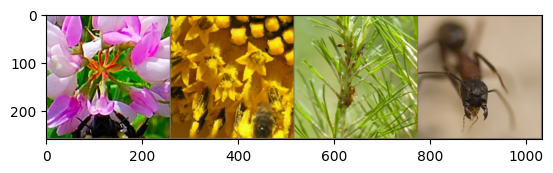

Classes:
bees bees ants ants


In [7]:
# show and review some images

# function to show an input image
def imshow(img, mean, std):
    """
    This function shows the actual image given the input pixel data

    Inputs:
        img: torch tensor
    """

    # convert to numpy and transpose
    npimg = img.numpy().transpose((1, 2, 0))

    # de-normalize
    npimg = npimg * std + mean
    npimg = np.clip(npimg, 0, 1)

    # show images
    plt.imshow(npimg)
    plt.show()
    
# get sample images
dataiter = iter(dataloaders["train"])
sample_inputs, sample_labels = next(dataiter)

# show images
sample_images = torchvision.utils.make_grid(sample_inputs)
imshow(sample_images, img_mean, img_std)
print("Classes:")
print(" ".join(classes[label] for label in sample_labels))

### Section 2: define training functions

In [15]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    """
    This function trains a given model on the train set, computes performance stats on both train and val, and saves the model with the best epoch level performances
    """

    since = time.time()

    with TemporaryDirectory() as tempdir:

        # save the model weights, and set it up for the saved weights to be updated 
        PATH = os.path.join(tempdir, "best_model_params.pt")
        torch.save(model.state_dict(), PATH)
        best_accuracy = 0.0

        # loop through epochs
        for epoch in range(num_epochs):

            print("Epoch: {epoch}/{num_epochs}".format(epoch=epoch, num_epochs=num_epochs-1))
            print("=" * 10)

            # each epoch has a train and a val phase
            for phase in ["train", "val"]:

                # initialize the model mode accordingly
                model.train() if phase == "train" else model.eval()

                # initialize performance stats
                running_loss = 0.0
                running_corrects = 0

                # loop through the dataset
                for inputs, labels in dataloaders[phase]:

                    # move data to the proper device
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward prop
                    # perform gradient related tasks only if in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, predicts = torch.max(outputs, 1)

                        # backward prop and update weights only if in train
                        loss.backward()
                        optimizer.step()

                    # update performance stats
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(predicts==labels.data)

                # update the scheduler
                if phase == "train":
                    scheduler.step()

                # aggregate the epoch level states
                epoch_loss = running_loss / len(datasets[phase])
                epoch_accuracy = running_corrects / len(datasets[phase])
                print("{phase} loss: {epoch_loss:.4f} accuracy: {epoch_accuracy:.4f}".format(phase=phase, epoch_loss=epoch_loss, epoch_accuracy=epoch_accuracy))

                # update saved model weights if needed
                if phase=="val" and epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    torch.save(model.state_dict(), PATH)

            print()
            
        # print training stats
        time_elapsed = time.time() - since
        print("Training completed in {min:.0f}m {sec:.0f}s".format(min=(time_elapsed//60), sec=(time_elapsed%60)))
        print("Best val accuracy: {accuracy:.4f}".format(accuracy=best_accuracy))
        print()
        
        # load the best model
        model.load_state_dict(torch.load(PATH))
        
    return model